#**Proyecto Final Machine Learning**

1. Se instalan las dependencias necesarias

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time


2. Leemos csv y vemos como es el dataset seleccionado

In [28]:
data = pd.read_csv('grammatical_facial_expressions.csv')
data.head()

,video_id,user,expression,frame,0,target
0,a_affirmative,a,affirmative,0,0.0 0x 0y 0z 1x 1y 1z 2x 2y 2z 3x 3y 3z 4x 4y ...,0.0
1,a_affirmative,a,affirmative,1,1390385453.172 244.672 208.182 895 240.949 205...,0.0
2,a_affirmative,a,affirmative,2,1390385453.313 265.953 195.731 1016 262.556 19...,0.0
3,a_affirmative,a,affirmative,3,1390385453.375 272.755 192.786 1060 269.481 19...,0.0
4,a_affirmative,a,affirmative,4,1390385453.531 281.89 190.533 1129 278.861 188...,0.0


3. Verificamos la columnas del dataset

In [29]:
print("Columnas del dataset:")
print(data.columns.tolist())
print(f"\nShape: {data.shape}")
print(f"\nPrimeras filas de la columna '0':")
print(data['0'].head())
print(f"\nTipo de dato en columna '0': {type(data['0'].iloc[0])}")

Columnas del dataset:
['video_id', 'user', 'expression', 'frame', '0', 'target']

Shape: (26641, 6)

Primeras filas de la columna '0':
0    0.0 0x 0y 0z 1x 1y 1z 2x 2y 2z 3x 3y 3z 4x 4y ...
1    1390385453.172 244.672 208.182 895 240.949 205...
2    1390385453.313 265.953 195.731 1016 262.556 19...
3    1390385453.375 272.755 192.786 1060 269.481 19...
4    1390385453.531 281.89 190.533 1129 278.861 188...
Name: 0, dtype: object

Tipo de dato en columna '0': <class 'str'>


4. Usamos LDA para la aseparación de clases

(LDA) Linear Discriminant Analysis busca combinaciones lineales de las características que maximicen la separabilidad entre clases.

Optimiza la razón entre la varianza entre clases y la varianza dentro de las clases, asumiendo que cada clase sigue una distribución normal con covarianza compartida.

El resultado son ejes (componentes) donde las clases quedan lo más separadas posible; esto sirve tanto para clasificación lineal como para reducir la dimensionalidad a 1 o 2 dimensiones y visualizar la separación de clases.

Longitudes de landmarks: min=1, max=301
Distribución de longitudes:
0
301    26607
1         17
Name: count, dtype: int64

Usando solo filas con 301 landmarks
Filas válidas: 26607 de 26624

Número de muestras: 26607
Número de características: 301
Clases únicas: [0. 1.]


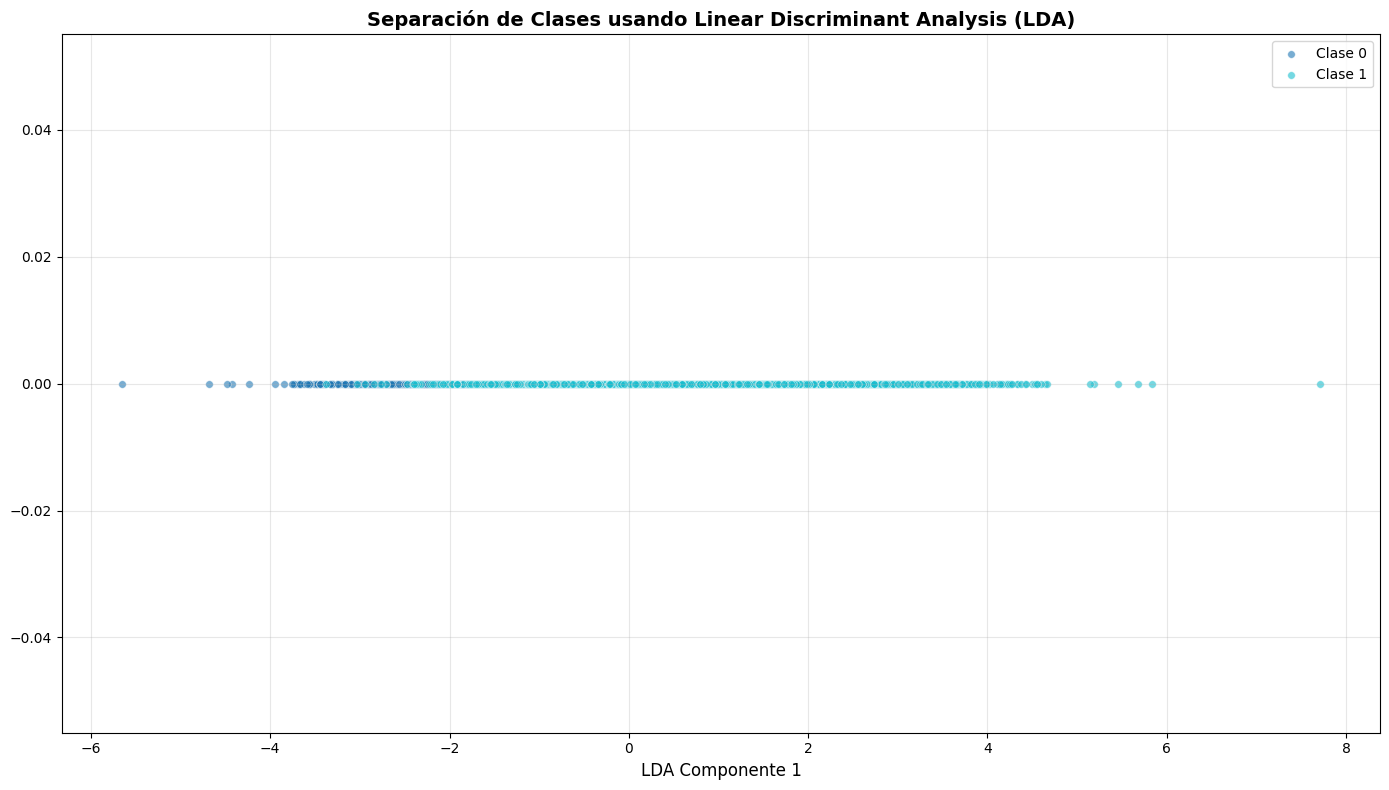


Varianza explicada por componente: [1.]
Varianza total explicada: 1.0000
Total de clases: 2


In [30]:
%matplotlib inline

# Primero, parseamos la columna '0' que contiene los landmarks
def parse_landmarks(landmark_str):
    """Convierte el string de landmarks en una lista de valores numéricos"""
    parts = str(landmark_str).split()
    # Filtramos solo los valores numéricos (ignoramos los headers como '0x', '0y', etc.)
    numeric_values = []
    for part in parts:
        try:
            numeric_values.append(float(part))
        except ValueError:
            continue
    return numeric_values

# Parseamos los landmarks y filtramos NaN en target
data_clean = data[data['target'].notna()].copy()
landmarks_parsed = data_clean['0'].apply(parse_landmarks)

# Verificar que todos tengan la misma longitud
lengths = landmarks_parsed.apply(len)
print(f"Longitudes de landmarks: min={lengths.min()}, max={lengths.max()}")
print(f"Distribución de longitudes:")
print(lengths.value_counts().head())

# Filtrar solo las filas que tienen la longitud más común (301)
expected_length = lengths.mode()[0]
mask_valid = lengths == expected_length
data_clean_filtered = data_clean[mask_valid].copy()
landmarks_parsed_filtered = landmarks_parsed[mask_valid]

print(f"\nUsando solo filas con {expected_length} landmarks")
print(f"Filas válidas: {mask_valid.sum()} de {len(mask_valid)}")

# Convertir a array numpy
X = np.array(landmarks_parsed_filtered.tolist())
y = data_clean_filtered['target'].values

print(f"\nNúmero de muestras: {X.shape[0]}")
print(f"Número de características: {X.shape[1]}")
print(f"Clases únicas: {np.unique(y)}")

# Aplicar LDA para reducir a 2 componentes (para visualización)
n_components = min(2, len(np.unique(y))-1)
lda = LDA(n_components=n_components)
X_lda = lda.fit_transform(X, y)

# Crear el scatter plot
plt.figure(figsize=(14, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(np.unique(y))))

for idx, label in enumerate(np.unique(y)):
    mask = y == label
    plt.scatter(X_lda[mask, 0], X_lda[mask, 1] if n_components > 1 else np.zeros(mask.sum()),
                label=f'Clase {int(label)}',
                alpha=0.6,
                edgecolors='w',
                linewidth=0.5,
                s=30,
                color=colors[idx])

plt.xlabel('LDA Componente 1', fontsize=12)
if n_components > 1:
    plt.ylabel('LDA Componente 2', fontsize=12)
plt.title('Separación de Clases usando Linear Discriminant Analysis (LDA)', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nVarianza explicada por componente: {lda.explained_variance_ratio_}")
print(f"Varianza total explicada: {lda.explained_variance_ratio_.sum():.4f}")
print(f"Total de clases: {len(np.unique(y))}")

#**MODELOS**

In [31]:
# Usar los datos ya procesados (X, y de la celda anterior)
print(f"Datos para entrenamiento:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Distribución de clases: {np.bincount(y.astype(int))}")

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalizar los datos (importante para algunos modelos)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nDatos de entrenamiento: {X_train.shape}")
print(f"Datos de prueba: {X_test.shape}")

Datos para entrenamiento:
X shape: (26607, 301)
y shape: (26607,)
Distribución de clases: [17221  9386]

Datos de entrenamiento: (21285, 301)
Datos de prueba: (5322, 301)


5. Función de verosimilitud logarítmica

Usamos la verosimilitud para estimar parámetros que maximicen la probabilidad de las etiquetas observadas. Optimizar la log-verosimilitud (equivalente a minimizar la pérdida logística) produce estimadores de máxima verosimilitud para este modelo binario.

In [32]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def log_likelihood(theta, X, y):
    z = X @ theta
    p = sigmoid(z)
    eps = 1e-9  # evita log(0)
    return np.sum(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))


def neg_log_likelihood(theta, X, y):
    return -log_likelihood(theta, X, y)


# Agregar término bias a los datos escalados
X_ll = np.hstack([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled])
y_ll = y_train

# Tomar una muestra para acelerar la optimización
sample_size = min(5000, X_ll.shape[0])
X_sample = X_ll[:sample_size]
y_sample = y_ll[:sample_size]

# Estimación de máxima verosimilitud vía L-BFGS-B
theta0 = np.zeros(X_sample.shape[1])
res = minimize(neg_log_likelihood, theta0, args=(X_sample, y_sample), method="L-BFGS-B")

grad_norm = np.linalg.norm(res.jac) if hasattr(res, "jac") else float("nan")
print(f"Log-verosimilitud óptima: {-res.fun:.4f}")
print(f"Iteraciones: {res.nit}")
print(f"Norma del gradiente final: {grad_norm:.4f}")


Log-verosimilitud óptima: -2387.6628
Iteraciones: 45
Norma del gradiente final: 455.4671


6. Modelos que vamos a utilizar, entrenamiento de todos

In [33]:
# Definir los modelos con sus parametros
modelos = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'SVM (Linear)': SVC(kernel='linear', random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
    'LDA': LDA()
}

# Entrenar y evaluar cada modelo
resultados = []

print("Entrenando modelos...\n")
print("="*80)

for nombre, modelo in modelos.items():
    print(f"\n -> Entrenando {nombre}...")

    # Medir tiempo de entrenamiento
    start_time = time.time()

    # Algunos modelos funcionan mejor con datos escalados
    if nombre in ['SVM (Linear)', 'SVM (RBF)', 'K-Nearest Neighbors', 'Neural Network', 'LDA']:
        modelo.fit(X_train_scaled, y_train)
        y_pred = modelo.predict(X_test_scaled)
    else:
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

    train_time = time.time() - start_time

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    resultados.append({
        'Modelo': nombre,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Tiempo (s)': train_time
    })

    print(f"   ✓ Accuracy: {accuracy:.4f}")
    print(f"   ✓ F1-Score: {f1:.4f}")
    print(f"   ✓ Tiempo: {train_time:.2f}s")

print("\n" + "="*80)
print(" Entrenamiento completado!")

# Crear DataFrame con resultados, los ordenamos para tener primero el de mayor accuracy
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values('Accuracy', ascending=False)
print("\n RESUMEN DE RESULTADOS:")
print(df_resultados.to_string(index=False))

Entrenando modelos...


 -> Entrenando Random Forest...
   ✓ Accuracy: 0.9350
   ✓ F1-Score: 0.9065
   ✓ Tiempo: 38.03s

 -> Entrenando SVM (Linear)...
   ✓ Accuracy: 0.8177
   ✓ F1-Score: 0.7075
   ✓ Tiempo: 424.44s

 -> Entrenando SVM (RBF)...
   ✓ Accuracy: 0.8497
   ✓ F1-Score: 0.7684
   ✓ Tiempo: 109.94s

 -> Entrenando K-Nearest Neighbors...
   ✓ Accuracy: 0.8557
   ✓ F1-Score: 0.7845
   ✓ Tiempo: 4.20s

 -> Entrenando Naive Bayes...
   ✓ Accuracy: 0.6022
   ✓ F1-Score: 0.4865
   ✓ Tiempo: 0.13s

 -> Entrenando Decision Tree...
   ✓ Accuracy: 0.8767
   ✓ F1-Score: 0.8275
   ✓ Tiempo: 13.81s

 -> Entrenando Gradient Boosting...
   ✓ Accuracy: 0.8606
   ✓ F1-Score: 0.7868
   ✓ Tiempo: 295.53s

 -> Entrenando AdaBoost...
   ✓ Accuracy: 0.7946
   ✓ F1-Score: 0.6721
   ✓ Tiempo: 106.42s

 -> Entrenando Neural Network...
   ✓ Accuracy: 0.8967
   ✓ F1-Score: 0.8528
   ✓ Tiempo: 80.62s

 -> Entrenando LDA...
   ✓ Accuracy: 0.8125
   ✓ F1-Score: 0.7008
   ✓ Tiempo: 1.53s

 Entrenamiento c

7. Comparación de los modelos con gráficas

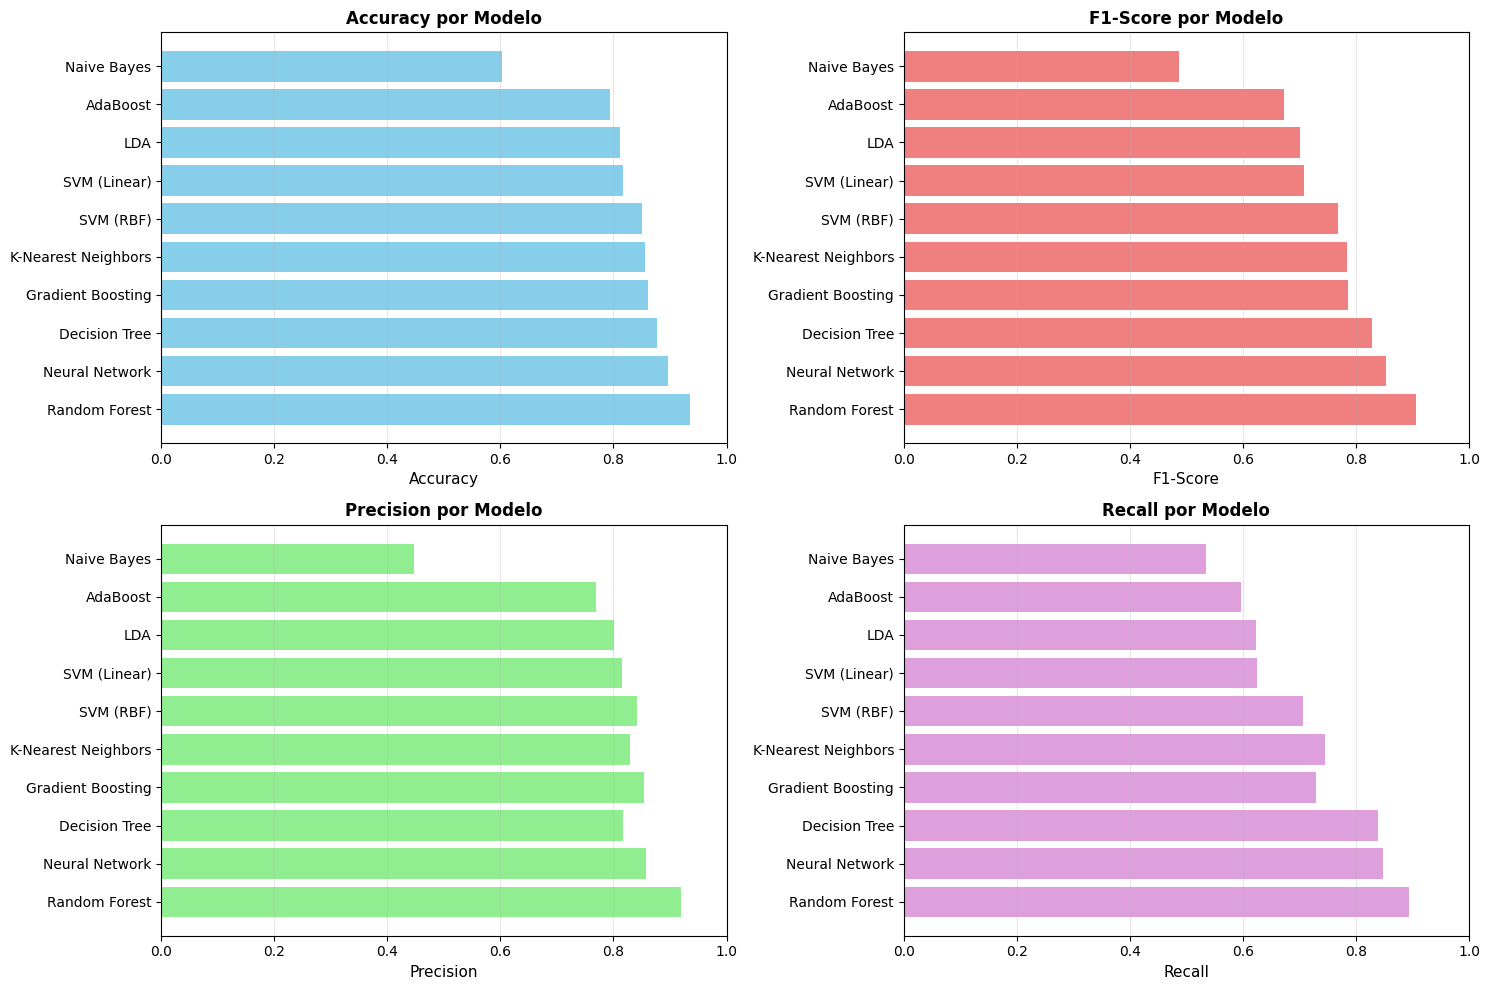

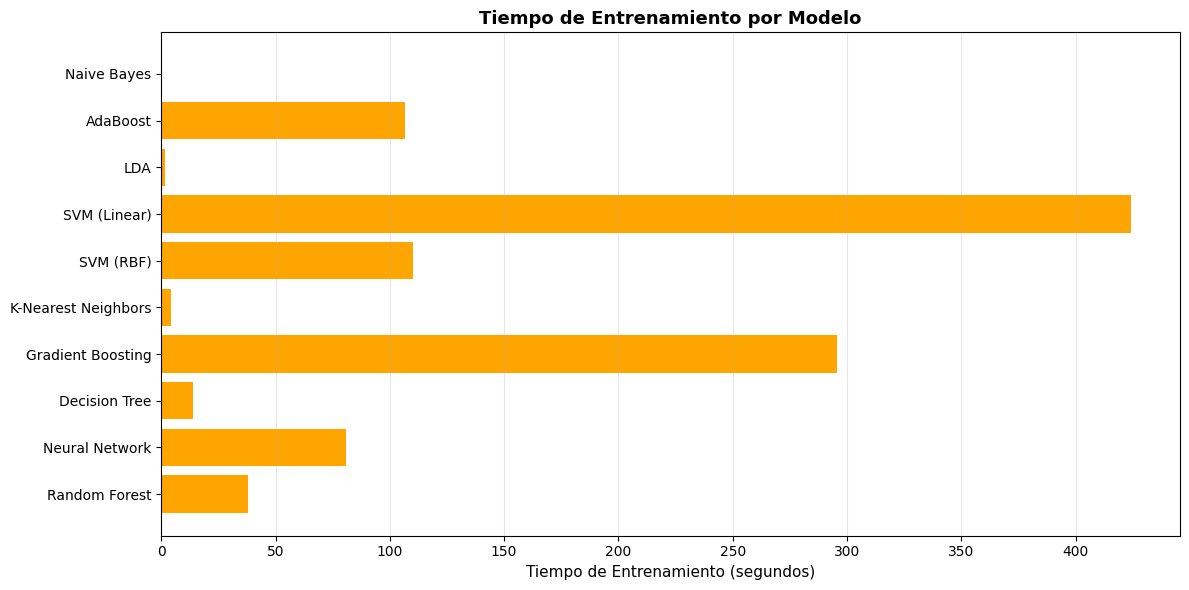

In [34]:
# Visualizar comparación de modelos
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].barh(df_resultados['Modelo'], df_resultados['Accuracy'], color='skyblue')
axes[0, 0].set_xlabel('Accuracy', fontsize=11)
axes[0, 0].set_title('Accuracy por Modelo', fontsize=12, fontweight='bold')
axes[0, 0].set_xlim(0, 1)
axes[0, 0].grid(axis='x', alpha=0.3)

# F1-Score
axes[0, 1].barh(df_resultados['Modelo'], df_resultados['F1-Score'], color='lightcoral')
axes[0, 1].set_xlabel('F1-Score', fontsize=11)
axes[0, 1].set_title('F1-Score por Modelo', fontsize=12, fontweight='bold')
axes[0, 1].set_xlim(0, 1)
axes[0, 1].grid(axis='x', alpha=0.3)

# Precision
axes[1, 0].barh(df_resultados['Modelo'], df_resultados['Precision'], color='lightgreen')
axes[1, 0].set_xlabel('Precision', fontsize=11)
axes[1, 0].set_title('Precision por Modelo', fontsize=12, fontweight='bold')
axes[1, 0].set_xlim(0, 1)
axes[1, 0].grid(axis='x', alpha=0.3)

# Recall
axes[1, 1].barh(df_resultados['Modelo'], df_resultados['Recall'], color='plum')
axes[1, 1].set_xlabel('Recall', fontsize=11)
axes[1, 1].set_title('Recall por Modelo', fontsize=12, fontweight='bold')
axes[1, 1].set_xlim(0, 1)
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Gráfico de tiempo de entrenamiento
plt.figure(figsize=(12, 6))
plt.barh(df_resultados['Modelo'], df_resultados['Tiempo (s)'], color='orange')
plt.xlabel('Tiempo de Entrenamiento (segundos)', fontsize=11)
plt.title('Tiempo de Entrenamiento por Modelo', fontsize=13, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

8. Selección del mejor modelo, reentrenarlo y mostrar matriz de confusión

* Mejor modelo: Random Forest
   Accuracy: 0.9350
   F1-Score: 0.9065

 Modelo final entrenado con 26607 muestras


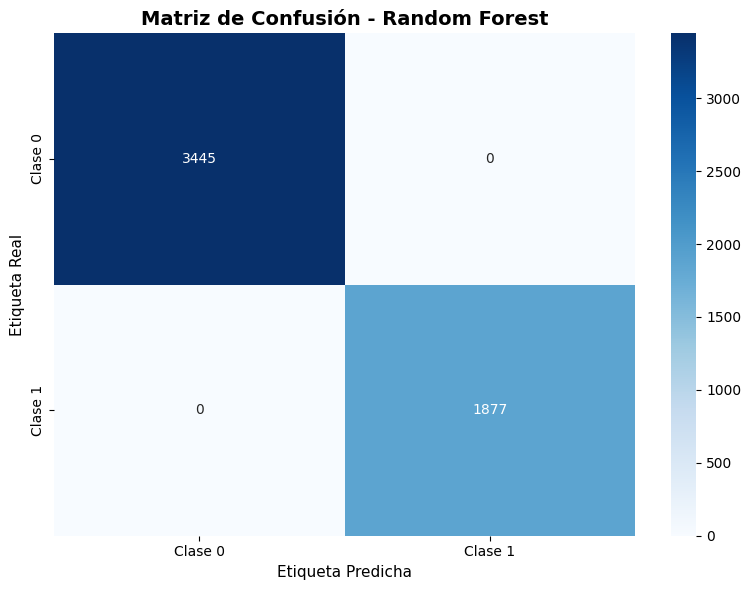

In [35]:
# Seleccionar el mejor modelo y entrenar con todos los datos
mejor_modelo_nombre = df_resultados.iloc[0]['Modelo']
print(f"* Mejor modelo: {mejor_modelo_nombre}")
print(f"   Accuracy: {df_resultados.iloc[0]['Accuracy']:.4f}")
print(f"   F1-Score: {df_resultados.iloc[0]['F1-Score']:.4f}")

# Re-entrenar el mejor modelo con todos los datos
mejor_modelo = modelos[mejor_modelo_nombre]

if mejor_modelo_nombre in ['SVM (Linear)', 'SVM (RBF)', 'K-Nearest Neighbors', 'Neural Network', 'LDA']:
    scaler_final = StandardScaler()
    X_scaled_final = scaler_final.fit_transform(X)
    mejor_modelo.fit(X_scaled_final, y)
    usar_scaler = True
else:
    mejor_modelo.fit(X, y)
    scaler_final = scaler
    usar_scaler = False

print(f"\n Modelo final entrenado con {X.shape[0]} muestras")

# Matriz de confusión del mejor modelo
if mejor_modelo_nombre in ['SVM (Linear)', 'SVM (RBF)', 'K-Nearest Neighbors', 'Neural Network', 'LDA']:
    y_pred_final = mejor_modelo.predict(X_test_scaled)
else:
    y_pred_final = mejor_modelo.predict(X_test)

cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Clase 0', 'Clase 1'],
            yticklabels=['Clase 0', 'Clase 1'])
plt.title(f'Matriz de Confusión - {mejor_modelo_nombre}', fontsize=14, fontweight='bold')
plt.ylabel('Etiqueta Real', fontsize=11)
plt.xlabel('Etiqueta Predicha', fontsize=11)
plt.tight_layout()
plt.show()

9. Guardar el modelo entrenado para la presentación 🙂

In [35]:
import pickle

# Guardar modelo y scaler
with open('modelo_facial_expressions.pkl', 'wb') as f:
    pickle.dump(mejor_modelo, f)

with open('scaler_facial_expressions.pkl', 'wb') as f:
    pickle.dump(scaler_final, f)

# Guardar información del modelo
model_info = {
    'nombre_modelo': mejor_modelo_nombre,
    'accuracy': df_resultados.iloc[0]['Accuracy'],
    'f1_score': df_resultados.iloc[0]['F1-Score'],
    'usar_scaler': usar_scaler,
    'num_features': X.shape[1],
    'clases': list(np.unique(y))
}

with open('modelo_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)

print("*** Modelo guardado exitosamente:")
print(f"   modelo_facial_expressions.pkl")
print(f"   scaler_facial_expressions.pkl")
print(f"   modelo_info.pkl")
print(f"\n Información del modelo:")
for key, value in model_info.items():
    print(f"   {key}: {value}")